In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import mlflow


from preprocessor.data_preprocessor import LeadScoringPreprocessor

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, roc_auc_score, precision_score, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, classification_report, roc_curve

from xgboost import XGBClassifier

## 1. Load Data

In [3]:
df = pd.read_csv('data/lead_scoring.csv')

In [4]:
X = df.drop('Converted', axis=1)
y = df['Converted']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 2. Preprocess Data

In [6]:
preprocessor = LeadScoringPreprocessor()
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity', 'Specialization', 'What is your current occupation']
['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']


## 3. Modelling

In [7]:
skfold = StratifiedKFold(5, shuffle=True, random_state=12)

### Training Utils

In [8]:
def display_scores(model,scores,pred):
  print(f'----------- {model} -----------')
  print('')
  print("------------------ Cross validation scores:")
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())
  print('')
  print("--------------- Scores in the training set:")
  print("Precision:", precision_score(y_train,pred))
  print("Recall:", recall_score(y_train,pred))
  print("F1 score:", f1_score(y_train,pred))
  print("ROC - AUC score:", roc_auc_score(y_train,pred))

### XGBOOST

In [9]:
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss', # Or 'auc' for Area Under ROC Curve
    use_label_encoder=False, # Suppresses a warning in newer versions
    random_state=42
)

In [10]:
xgb_scores = cross_val_score(xgb_model, X_train, y_train,
                            cv=skfold, scoring='f1')

In [11]:
# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [12]:
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

In [13]:
lead_scores = y_pred_proba * 100

In [14]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.8827


In [15]:
y_pred = (y_pred_proba > 0.5).astype(int)

In [16]:
xgb_pred = xgb_model.predict(X_train)

In [17]:
# Precision and recall curve
xgb_prec, xgb_recall, xgb_threshold = precision_recall_curve(y_train, xgb_pred, pos_label=xgb_model.classes_[1])
xgb_prdisplay = PrecisionRecallDisplay(precision=xgb_prec, recall=xgb_recall)

In [18]:
# Display Scores
display_scores('XGB',xgb_scores,xgb_pred)

----------- XGB -----------

------------------ Cross validation scores:
Scores: [0.77316858 0.77448338 0.77484047 0.75940507 0.76283186]
Mean: 0.7689458728087247
Standard deviation: 0.006506143936148424

--------------- Scores in the training set:
Precision: 0.8868267831149927
Recall: 0.8553878553878553
F1 score: 0.870823655529748
ROC - AUC score: 0.893465444312902


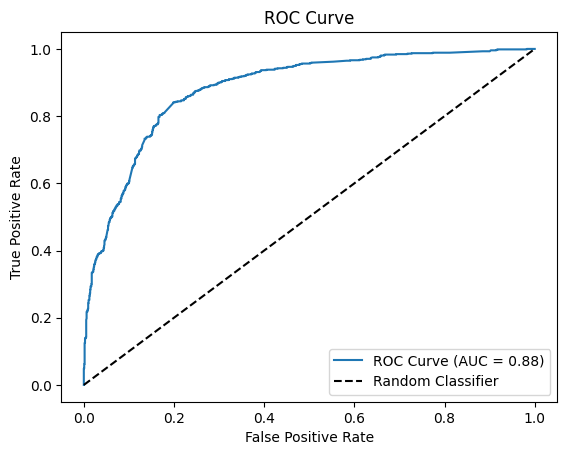

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Text(120.72222222222221, 0.5, 'True')

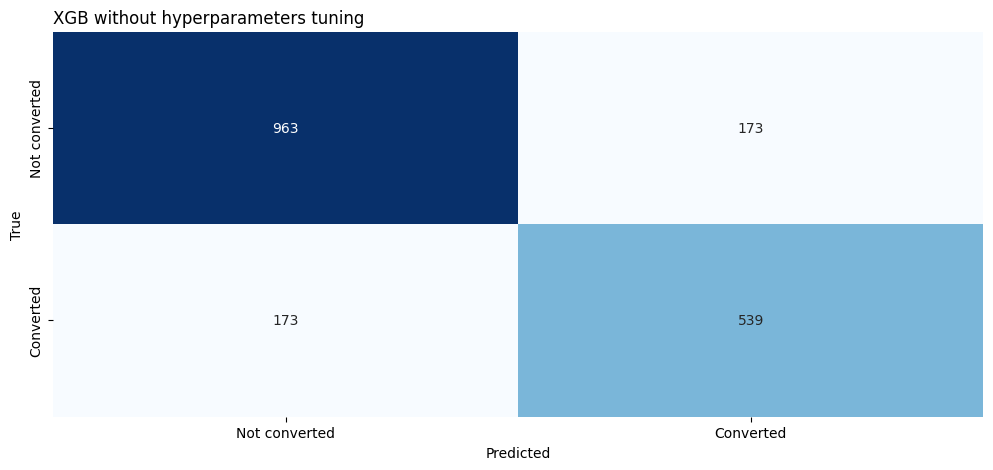

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
ax.xaxis.set_ticklabels(['Not converted', 'Converted'])
ax.yaxis.set_ticklabels(['Not converted', 'Converted'])
ax.set_title('XGB without hyperparameters tuning', loc='left')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [21]:
# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names()

                                              feature  importance
2               pipeline-1__Lead Origin_Lead Add Form    0.492044
48  pipeline-1__What is your current occupation_Wo...    0.070341
47  pipeline-1__What is your current occupation_Un...    0.059567
23           pipeline-1__Last Activity_SMS/Email Sent    0.054969
14                         pipeline-1__Do Not Email_0    0.024178
50            pipeline-2__Total Time Spent on Website    0.019637
20  pipeline-1__Last Activity_Olark Chat Conversation    0.017606
45  pipeline-1__What is your current occupation_St...    0.010756
18             pipeline-1__Last Activity_Email Opened    0.010267
1     pipeline-1__Lead Origin_Landing Page Submission    0.010034
41                 pipeline-1__Specialization_Unknown    0.009876
0                         pipeline-1__Lead Origin_API    0.009701
30  pipeline-1__Specialization_Hospitality Management    0.009362
16        pipeline-1__Last Activity_Converted to Lead    0.008978
51        

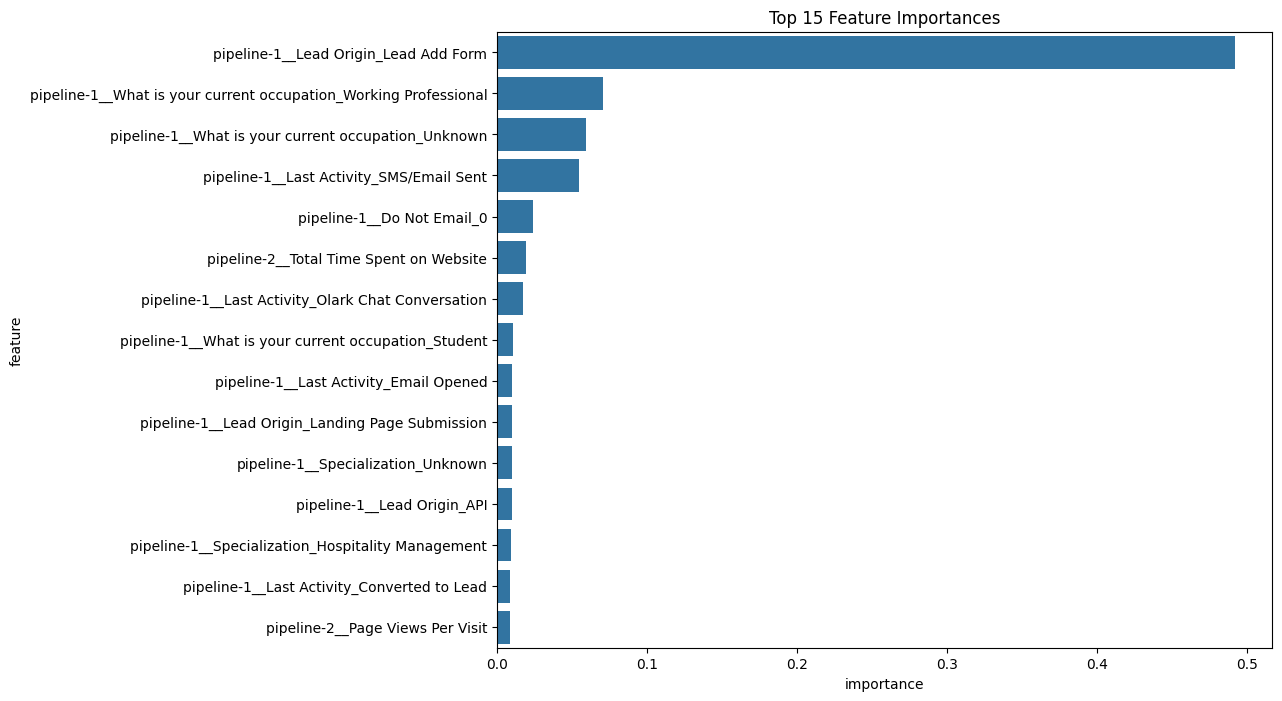

In [22]:
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_ # or best_xgb_model.feature_importances_ if you tuned
}).sort_values('importance', ascending=False)

print(feature_importances)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.show()

### Hyperparameters Tuning
Using `Optuna` and `MLFlow`

In [27]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")


In [28]:
def objective_xgboost(trial):
    """
    Objective function for XGBoost hyperparameter optimization.
    """
    with mlflow.start_run(nested=True):
        # Define hyperparameter search space
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 9),
            'random_state': 42,
            'use_label_encoder': False
        }
        
        mlflow.log_params(params)
        
        # Create model
        model = XGBClassifier(**params)
    
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_train, y_train, 
                            cv=cv, scoring='roc_auc')
    
        mean_score = scores.mean()
        mlflow.log_metric("cv_roc_auc_mean", mean_score)
        mlflow.log_metric("cv_roc_auc_std", scores.std())
        
    
    return mean_score

In [29]:
mlflow.set_experiment("XGBoost Lead Scoring with Optuna")
with mlflow.start_run(run_name="Hyperparameter Tuning Study"):
    # The main parent run for the entire optimization process
    
    # Define a study and optimize the objective function
    # We want to maximize ROC AUC, so direction='maximize'
    study = optuna.create_study(direction="maximize")

    # The optimize method will run the objective function n_trials times
    study.optimize(objective_xgboost, n_trials=50, show_progress_bar=True)
    
    # Log the best parameters and best metric to the parent run
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_roc_auc", study.best_value)

    # Print the best trial results
    print("\nOptimization finished.")
    print(f"Best trial (ROC AUC): {study.best_value}")
    print(f"Best parameters: {study.best_params}")

    # You can get the best model from the best trial's parameters and retrain it on the full data
    best_params = study.best_params
    best_model = XGBClassifier(**best_params, use_label_encoder=False)

[I 2025-08-07 16:47:09,611] A new study created in memory with name: no-name-84aaa904-a32d-4e1b-a1f1-8cb35e86aced


  0%|          | 0/50 [00:00<?, ?it/s]

🏃 View run melodic-ant-309 at: http://127.0.0.1:8080/#/experiments/511580030993890231/runs/fc24af77b3034e60992a8a104c74a51b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/511580030993890231
[I 2025-08-07 16:47:10,735] Trial 0 finished with value: 0.9067626849664684 and parameters: {'lambda': 0.6460152491927778, 'alpha': 0.00020073168322352634, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.04586071557757032, 'n_estimators': 171, 'max_depth': 7}. Best is trial 0 with value: 0.9067626849664684.
🏃 View run wise-shoat-577 at: http://127.0.0.1:8080/#/experiments/511580030993890231/runs/8e78a47e6397494dacb65022454608cc
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/511580030993890231
[I 2025-08-07 16:47:11,565] Trial 1 finished with value: 0.905773280456868 and parameters: {'lambda': 6.037918123796403e-07, 'alpha': 6.326824787054236e-07, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.01914297567354566, 'n_estimators': 228, 'max_depth': 4}. 

In [30]:
best_model.fit(X_train, y_train)

XGBClassifier(alpha=1.734360177201156e-06, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=8.839196044984967e-06, learning_rate=0.032151590969685784,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=272, ...)

In [31]:
y_pred = best_model.predict(X_test)

Text(120.72222222222221, 0.5, 'True')

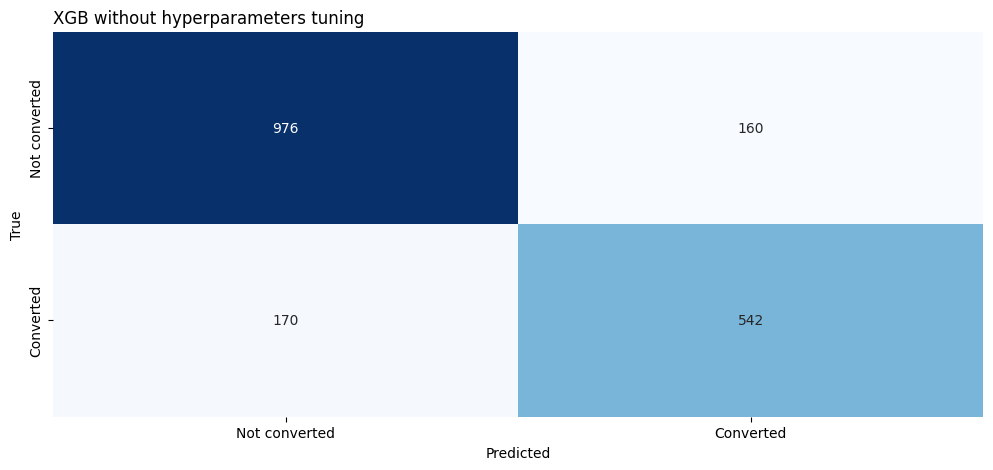

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
ax.xaxis.set_ticklabels(['Not converted', 'Converted'])
ax.yaxis.set_ticklabels(['Not converted', 'Converted'])
ax.set_title('XGB without hyperparameters tuning', loc='left')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [33]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

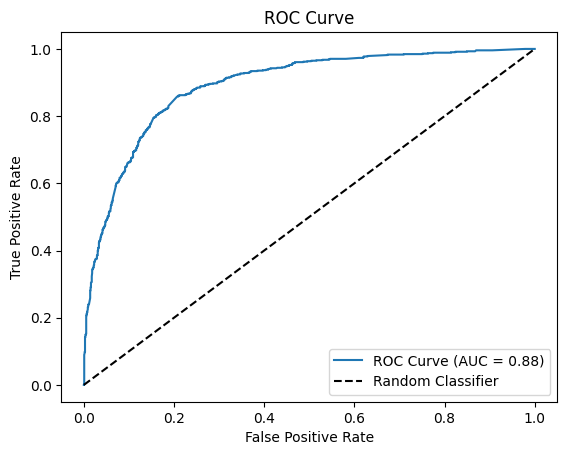

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Saving Model and Preprocessor

In [23]:
import joblib

In [24]:
# --- 4. Save the Model and Preprocessor ---
model_filename = 'models/xgb_lead_scoring_model.joblib'
preprocessor_filename = 'preprocessor/lead_scoring_preprocessor.joblib'
feature_names_filename = 'models/lead_scoring_feature_names.joblib' # Optional, but very useful

joblib.dump(xgb_model, model_filename)
joblib.dump(preprocessor, preprocessor_filename)
joblib.dump(feature_names, feature_names_filename) # Save feature names too!

print(f"\nModel saved to: {model_filename}")
print(f"Preprocessor saved to: {preprocessor_filename}")
print(f"Feature names saved to: {feature_names_filename}")


Model saved to: models/xgb_lead_scoring_model.joblib
Preprocessor saved to: preprocessor/lead_scoring_preprocessor.joblib
Feature names saved to: models/lead_scoring_feature_names.joblib
